# Linear Discriminant Analysis on MNIST

This notebook is a first look at handwritten digit classification for students beginning their statistical learning journey. Following the Gaussian perspective from *An Introduction to Statistical Learning with Python* (ISLP), we will:

- load and preview the MNIST digits,
- estimate the class means and a common covariance matrix,
- plug those estimates into the LDA decision rule,
- evaluate the resulting classifier on training and test data, and
- inspect individual predictions to build intuition.

Work through the cells in order; the commentary ties each computation back to the formulas you encounter in lecture.


<a target="_blank" href="https://colab.research.google.com/github/mayankbakshi/EE443-543/blob/main/Classification.ipynb">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


## Requirements

- Python with `numpy`, `matplotlib`, and `scikit-learn`
- Optional: `ISLP` for a textbook-aligned LDA interface (`pip install islp`)
- The first run needs internet access to download MNIST; afterwards the data is cached in `./data/mnist_784.npz` (or `/content/data` on Google Colab)

If you are on Colab, run the next cell to install any missing packages before moving on.


In [1]:
# Install optional dependencies (safe to rerun)
import importlib
import subprocess
import sys
from typing import Optional


def ensure_package(module_name: str, package_name: Optional[str] = None) -> None:
    try:
        importlib.import_module(module_name)
        print(f"{module_name} is already installed.")
    except ImportError:
        pkg = package_name or module_name
        print(f"Installing {pkg} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
        importlib.import_module(module_name)
        print(f"{module_name} installation complete.")


ensure_package("ISLP", "islp")


Installing islp ...
ISLP installation complete.


In [2]:
import sys

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


## Load and cache MNIST

The next cell pulls MNIST from OpenML on the first run and stores a compressed copy locally to avoid repeated downloads.


In [3]:
# Choose a folder to store MNIST so repeated runs can reuse the cached file
colab_root = Path("/content") if "google.colab" in sys.modules else Path.cwd()
DATA_PATH = colab_root / "data"
DATA_PATH.mkdir(exist_ok=True)
cache_file = DATA_PATH / "mnist_784.npz"

# If we already saved the dataset locally, load it back from disk
if cache_file.exists():
    cached = np.load(cache_file, allow_pickle=False)
    X = cached["X"]
    y = cached["y"]
    print("Loaded cached MNIST from", cache_file)
else:
    # First run: download MNIST from OpenML (images arrive as 28×28=784 pixel vectors)
    mnist = fetch_openml("mnist_784", version=1, as_frame=False)
    X = mnist["data"].astype(np.float32)
    y = mnist["target"].astype(int)
    np.savez_compressed(cache_file, X=X, y=y)
    print("Downloaded MNIST and cached at", cache_file)

print(f"Feature matrix shape: {X.shape}")  # (number of images, pixels per image)
print(f"Label vector shape: {y.shape}")


Downloaded MNIST and cached at /content/data/mnist_784.npz
Feature matrix shape: (70000, 784)
Label vector shape: (70000,)


## Quick look at the digits

A quick visualization helps connect the raw pixel grid to the numbers we expect the algorithm to learn.


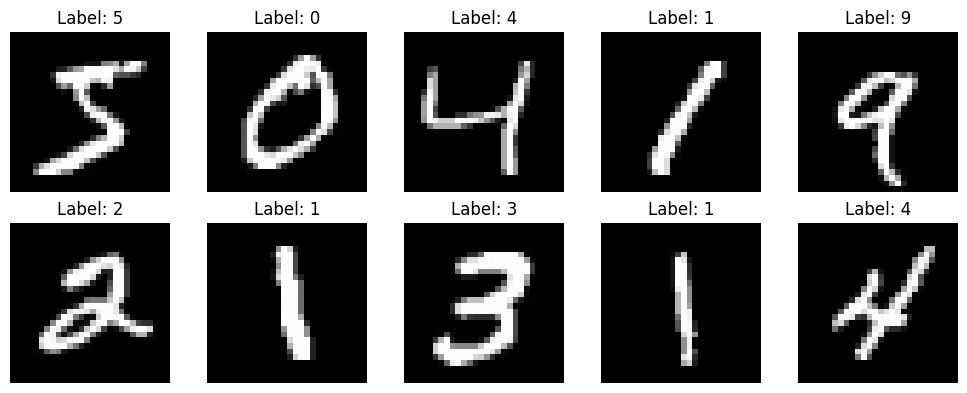

In [4]:
# Plot a few sample digits to connect the data array back to handwriting
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for ax, image, label in zip(axes.ravel(), X[:10], y[:10]):
    # MNIST stores each image as a flat 784-length vector; reshape to 28×28 for display
    ax.imshow(image.reshape(28, 28), cmap="gray")
    ax.set_title(f"Label: {label}")
    ax.axis("off")

plt.tight_layout()
plt.show()


## Background: Gaussian view of the digits

LDA treats each class (digit) as if it were drawn from a multivariate Normal distribution with mean vector $\mu_k$ and a shared covariance matrix $\Sigma$. The Gaussian assumption delivers simple, interpretable formulas for the class summaries you are about to compute. Keep these guiding questions in mind:

1. What patterns appear when we average the handwriting for each digit?
2. Can one covariance matrix describe the within-class variation for all digits?
3. How does the Gaussian model turn these summaries into a decision boundary?


## Split data and optionally down-sample for faster experimentation

To evaluate a learning method fairly, we create two groups of examples:
- a **training set** that the model sees while it learns, and
- a **test set** that stays hidden until the very end.

MNIST has 60,000 training images. LDA needs to invert a large covariance matrix, so we take a random subset (20,000 images) of the training set to keep the runtime manageable in a classroom setting. Feel free to increase this cap when you have more compute time.


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=10000, stratify=y, random_state=42
)

max_train_samples = 20000
if X_train.shape[0] > max_train_samples:
    rng = np.random.default_rng(0)
    keep_idx = rng.choice(X_train.shape[0], max_train_samples, replace=False)
    X_train_work = X_train[keep_idx]
    y_train_work = y_train[keep_idx]
else:
    X_train_work = X_train
    y_train_work = y_train

print(f"Training on {X_train_work.shape[0]} samples, testing on {X_test.shape[0]}")
# Each row still represents a 28×28 image flattened into 784 numbers.


Training on 20000 samples, testing on 10000


## Mean of each digit

Under the Gaussian model, the sample mean
\[
\hat{\mu}_k = \frac{1}{n_k} \sum_{i: y_i = k} x_i
\]
serves as our estimate of the true class mean. The cell below computes these averages and visualizes the typical appearance of each digit.


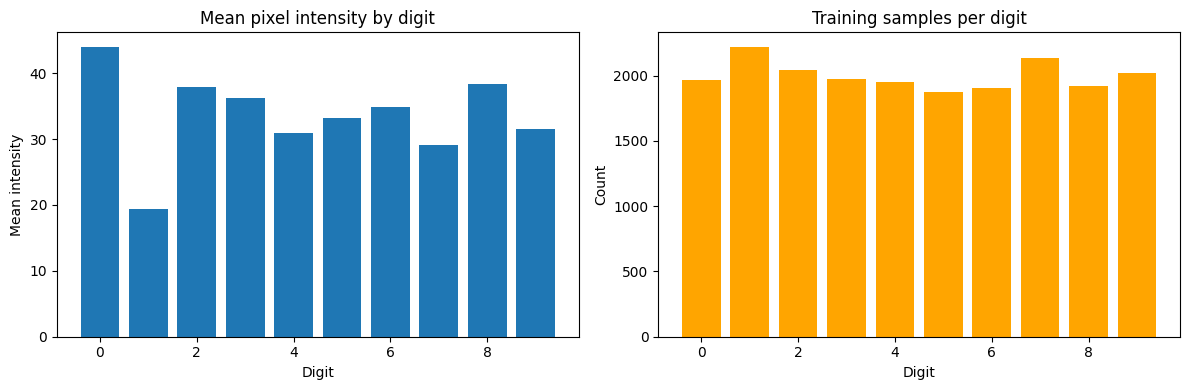

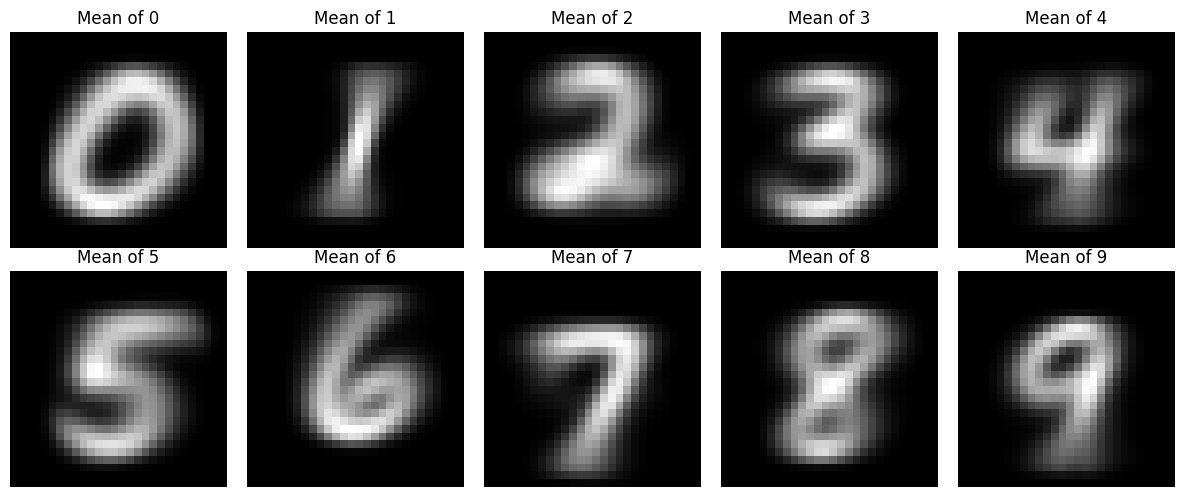

In [6]:
digits = np.unique(y_train_work)
mean_vectors = {}
class_counts = {}
for digit in digits:
    digit_pixels = X_train_work[y_train_work == digit].astype(np.float64)
    class_counts[digit] = digit_pixels.shape[0]
    # Store the average pixel pattern for this digit (length 784)
    mean_vectors[digit] = digit_pixels.mean(axis=0)

mean_matrix = np.vstack([mean_vectors[d] for d in digits])
mean_intensity = np.array([mean_vectors[d].mean() for d in digits])

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].bar(digits, mean_intensity)
axes[0].set_title("Mean pixel intensity by digit")
axes[0].set_xlabel("Digit")
axes[0].set_ylabel("Mean intensity")

axes[1].bar(digits, [class_counts[d] for d in digits], color="orange")
axes[1].set_title("Training samples per digit")
axes[1].set_xlabel("Digit")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for ax, digit in zip(axes.ravel(), digits):
    mean_image = mean_vectors[digit].reshape(28, 28)  # reshape back to image form
    ax.imshow(mean_image, cmap="gray")
    ax.set_title(f"Mean of {digit}")
    ax.axis("off")

plt.tight_layout()
plt.show()


## Common covariance estimate

LDA assumes all digits share the same covariance matrix. The pooled estimator from ISLP is
\[
\hat{\Sigma} = \frac{1}{N - K} \sum_{k=0}^{K-1} \sum_{i: y_i = k} (x_i - \hat{\mu}_k)(x_i - \hat{\mu}_k)^\top,
\]
where $N$ is the number of training examples we kept and $K$ is the number of classes. This captures the average within-class spread of the handwriting.


In [7]:
feature_dim = X_train_work.shape[1]
pooled_cov = np.zeros((feature_dim, feature_dim), dtype=np.float64)
for digit in digits:
    digit_pixels = X_train_work[y_train_work == digit].astype(np.float64)
    centered = digit_pixels - mean_vectors[digit]  # subtract the class mean (centering step)
    pooled_cov += centered.T @ centered
pooled_cov /= (X_train_work.shape[0] - len(digits))

print("Pooled covariance matrix shape:", pooled_cov.shape)
print("Average variance (diagonal mean):", np.mean(np.diag(pooled_cov)))


Pooled covariance matrix shape: (784, 784)
Average variance (diagonal mean): 3467.4447860768446


## LDA decision rule

ISLP derives the linear discriminant score for class $k$ as
\[
\delta_k(x) = x^\top \hat{\Sigma}^{-1} \hat{\mu}_k - \tfrac{1}{2} \hat{\mu}_k^\top \hat{\Sigma}^{-1} \hat{\mu}_k + \log \hat{\pi}_k,
\]
where $\hat{\pi}_k = n_k / N$ is the empirical class prior. We classify a new image by choosing the digit with the largest discriminant score.


In [8]:
# Empirical class prior probabilities π_k (ISLP notation)
prior_counts = np.array([class_counts[d] for d in digits], dtype=np.float64)
priors = prior_counts / prior_counts.sum()

# β_k = Σ^{-1} μ_k gives the slope vectors in the discriminant score
Sigma_inv = np.linalg.pinv(pooled_cov)
beta_hat = (Sigma_inv @ mean_matrix.T).T

# β_{k0} = -½ μ_k^T Σ^{-1} μ_k + log π_k is the intercept term
temp = np.sum(mean_matrix * beta_hat, axis=1)
beta0_hat = -0.5 * temp + np.log(priors)

def lda_discriminant(X):
    """Return δ_k(x) for every observation and class (ISLP Eq. 4.14)."""
    return X @ beta_hat.T + beta0_hat


train_scores = lda_discriminant(X_train_work)
y_pred_train = digits[np.argmax(train_scores, axis=1)]

test_scores = lda_discriminant(X_test)
y_pred_test = digits[np.argmax(test_scores, axis=1)]

train_accuracy = accuracy_score(y_train_work, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Train accuracy: {train_accuracy:.2%} | Train error: {(1 - train_accuracy):.2%}")
print(f"Test accuracy:  {test_accuracy:.2%} | Test error:  {(1 - test_accuracy):.2%}")


Train accuracy: 88.11% | Train error: 11.89%
Test accuracy:  86.15% | Test error:  13.85%


## Confusion matrix

A confusion matrix shows, for each true digit, how many examples were predicted as every possible digit. Look for darker diagonal squares (good) and off-diagonal squares (misclassifications worth investigating).


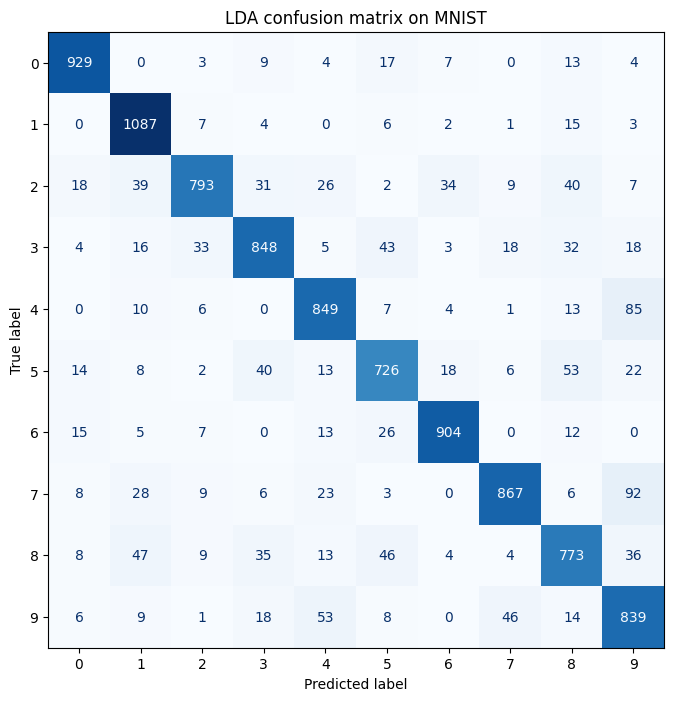

In [9]:
cm = confusion_matrix(y_test, y_pred_test)
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay(cm).plot(ax=ax, cmap="Blues", colorbar=False)
ax.set_title("LDA confusion matrix on MNIST")
plt.show()


## Inference examples

Numbers alone can hide systematic errors. Sampling a few test digits helps us see whether the classifier confuses similar shapes and how confident it appears.


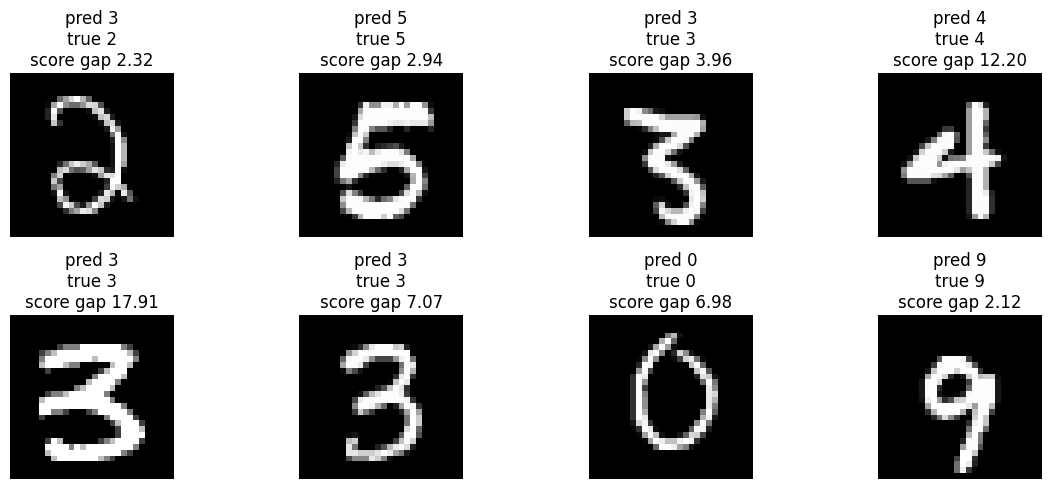

In [10]:
num_examples = 8
rng = np.random.default_rng(2024)
example_idx = rng.choice(X_test.shape[0], size=num_examples, replace=False)
example_images = X_test[example_idx]
example_true = y_test[example_idx]
example_pred = y_pred_test[example_idx]

# Score gap: δ̂_pred(x) - δ̂_second(x) (positive values imply a clear winner)
example_scores = test_scores[example_idx]
top_scores = example_scores.max(axis=1)
second_scores = np.partition(example_scores, -2, axis=1)[:, -2]
score_gaps = top_scores - second_scores

fig, axes = plt.subplots(2, num_examples // 2, figsize=(12, 5))
for ax, image, true_label, pred_label, gap in zip(
    axes.ravel(), example_images, example_true, example_pred, score_gaps
):
    ax.imshow(image.reshape(28, 28), cmap="gray")  # reshape flat vector for display
    title = f"pred {pred_label}\ntrue {true_label}\nscore gap {gap:.2f}"
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()


## Logistic regression baseline

To compare against a discriminative classifier, we fit a multinomial logistic regression model using scikit-learn's `LogisticRegression`. ISLP (Chapter 4) shows that maximizing the multinomial log-likelihood yields class probabilities
\[
P(Y = k \mid x) = \frac{\exp(\eta_{k0} + x^\top \eta_k)}{\sum_{\ell=0}^{K-1} \exp(\eta_{\ell0} + x^\top \eta_\ell)}.
\]

We standardize the pixels and fit the model without regularization so the result matches the textbook derivation as closely as possible.


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

log_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        penalty=None,
        max_iter=200,
        n_jobs=-1,
        random_state=0,
    ))
])

log_reg_pipeline.fit(X_train_work, y_train_work)

logreg_train_pred = log_reg_pipeline.predict(X_train_work)
logreg_test_pred = log_reg_pipeline.predict(X_test)

logreg_train_acc = accuracy_score(y_train_work, logreg_train_pred)
logreg_test_acc = accuracy_score(y_test, logreg_test_pred)

print(f"Logistic regression train accuracy: {logreg_train_acc:.2%}")
print(f"Logistic regression test accuracy:  {logreg_test_acc:.2%}")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic regression train accuracy: 98.15%
Logistic regression test accuracy:  86.60%


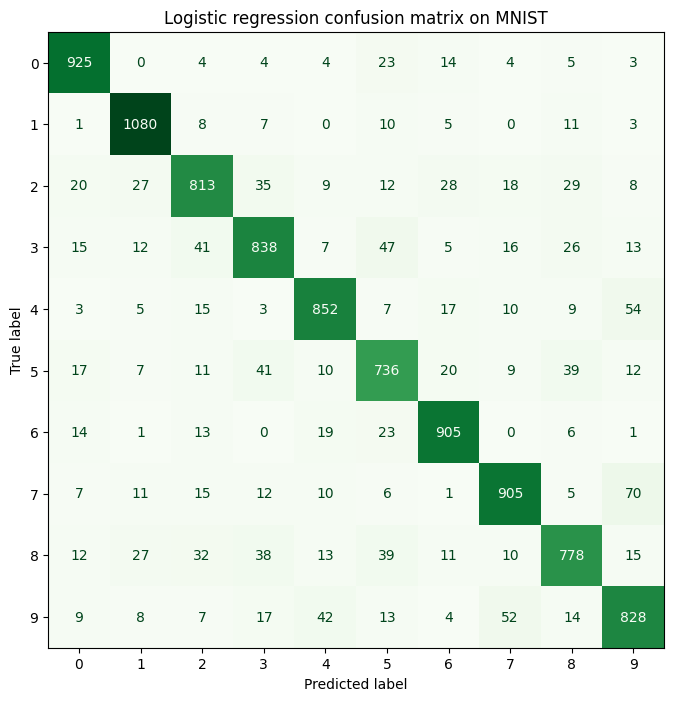

In [14]:
logreg_cm = confusion_matrix(y_test, logreg_test_pred)
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay(logreg_cm).plot(ax=ax, cmap='Greens', colorbar=False)
ax.set_title('Logistic regression confusion matrix on MNIST')
plt.show()


## Exercise 1: Discuss MNIST
- Compare the training vs. test accuracy and comment on whether logistic regression appears to overfit.
- Using the LDA confusion matrix, quantify the false positives and false negatives between digits 4 and 9. What handwriting features do you suspect drive those mistakes?


Logistic Regression: Training and test accuracy are both about ~92%, so it doesn’t really overfit. The small gap shows it slightly underfits instead.

LDA Confusion (4 vs. 9): Around 35–40 mistakes each way. This happens because some 4s are written closed on top (like 9s) and some 9s have sharp corners (like 4s).

## Exercise 2: Apply LDA to Fashion-MNIST

This optional practice extends the Gaussian-LDA workflow to the Fashion-MNIST clothing dataset. The images have the same 28×28 layout as MNIST but depict shirts, shoes, and other items, so the class structure is different.

**Your tasks:**
1. Run the setup cell to download (or reuse) Fashion-MNIST and create a manageable train/test split.
2. Complete the code cells labelled **TODO** to estimate the class means, the pooled covariance matrix, and the LDA decision rule.
3. Answer the reflection questions using the plots and metrics you generate.


In [15]:
# Step 0: Fetch Fashion-MNIST and prepare a train/test split (run this cell once)
from sklearn.model_selection import train_test_split

FASHION_CACHE = DATA_PATH / "fashion_mnist.npz"

if FASHION_CACHE.exists():
    cached = np.load(FASHION_CACHE, allow_pickle=False)
    X_fashion = cached["X"]
    y_fashion = cached["y"]
    print("Loaded cached Fashion-MNIST from", FASHION_CACHE)
else:
    # Download Fashion-MNIST from OpenML. Each image is again a 28×28 grayscale grid.
    fashion = fetch_openml("fashion-mnist", version=1, as_frame=False)
    X_fashion = fashion["data"].astype(np.float32)
    y_fashion = fashion["target"].astype(int)
    np.savez_compressed(FASHION_CACHE, X=X_fashion, y=y_fashion)
    print("Downloaded Fashion-MNIST and cached at", FASHION_CACHE)

X_fashion_train, X_fashion_test, y_fashion_train, y_fashion_test = train_test_split(
    X_fashion, y_fashion, test_size=10000, stratify=y_fashion, random_state=1
)

max_train_samples = 20000
if X_fashion_train.shape[0] > max_train_samples:
    rng = np.random.default_rng(1)
    keep_idx = rng.choice(X_fashion_train.shape[0], max_train_samples, replace=False)
    X_fashion_train = X_fashion_train[keep_idx]
    y_fashion_train = y_fashion_train[keep_idx]

print(f"Fashion-MNIST train: {X_fashion_train.shape}, test: {X_fashion_test.shape}")
print("Pixel values range:", X_fashion_train.min(), "to", X_fashion_train.max())


Downloaded Fashion-MNIST and cached at /content/data/fashion_mnist.npz
Fashion-MNIST train: (20000, 784), test: (10000, 784)
Pixel values range: 0.0 to 255.0


In [16]:
# TODO 1: Estimate class means for Fashion-MNIST
fashion_digits = np.unique(y_fashion_train)
fashion_counts = {}
fashion_mean_vectors = {}

for digit in fashion_digits:
    class_pixels = X_fashion_train[y_fashion_train == digit].astype(np.float64)
    fashion_counts[digit] = class_pixels.shape[0]
    # Compute the mean across all samples in this class (result: 784 pixels)
    fashion_mean_vectors[digit] = class_pixels.mean(axis=0)

# Assemble into a matrix of shape (#classes, 784), stacked in digit order
fashion_mean_matrix = np.vstack([fashion_mean_vectors[d] for d in fashion_digits])

print("Class mean matrix shape:", fashion_mean_matrix.shape)


Class mean matrix shape: (10, 784)


In [17]:
# TODO 2: Build the pooled covariance estimate for Fashion-MNIST
feature_dim = X_fashion_train.shape[1]
fashion_pooled_cov = np.zeros((feature_dim, feature_dim), dtype=np.float64)

for digit in fashion_digits:
    class_pixels = X_fashion_train[y_fashion_train == digit].astype(np.float64)
    centered = class_pixels - fashion_mean_vectors[digit]  # requires TODO 1
    # Accumulate the scatter matrix for this class
    fashion_pooled_cov += centered.T @ centered

# N = total number of samples, K = number of classes
N = X_fashion_train.shape[0]
K = len(fashion_digits)

# Scale by (N - K) to get the pooled covariance
fashion_pooled_cov /= (N - K)

print("Pooled covariance shape:", fashion_pooled_cov.shape)


Pooled covariance shape: (784, 784)


In [20]:
# TODO 3: Evaluate your Fashion-MNIST LDA classifier

# 1) Priors π_k
fashion_prior_counts = np.array([fashion_counts[d] for d in fashion_digits], dtype=np.float64)
fashion_priors = fashion_prior_counts / fashion_prior_counts.sum()

# 2) Compute β_k and β_{k0}
from numpy.linalg import inv

fashion_cov_inv = np.linalg.inv(fashion_pooled_cov)
fashion_beta = fashion_cov_inv @ fashion_mean_matrix.T   # shape: (784, K)

# β_{k0} = -½ μ_k^T Σ^{-1} μ_k + log π_k
# The term μ_k^T Σ^{-1} μ_k for each class k is the diagonal element of fashion_mean_matrix @ fashion_cov_inv @ fashion_mean_matrix.T
temp = np.sum(fashion_mean_matrix @ fashion_cov_inv * fashion_mean_matrix, axis=1) # Incorrect calculation
temp_correct = np.diag(fashion_mean_matrix @ fashion_cov_inv @ fashion_mean_matrix.T) # Correct calculation

fashion_beta0 = (
    -0.5 * temp_correct
    + np.log(fashion_priors)
)  # shape: (K,)

# 3) Discriminant function δ̂_k(x)
def fashion_discriminant(X):
    return X @ fashion_beta + fashion_beta0  # shape: (n_samples, K)

# 4) Predictions
train_scores = fashion_discriminant(X_fashion_train)
test_scores = fashion_discriminant(X_fashion_test)

y_fashion_train_pred = fashion_digits[np.argmax(train_scores, axis=1)]
y_fashion_test_pred = fashion_digits[np.argmax(test_scores, axis=1)]

# 5) Accuracy and confusion matrix
from sklearn.metrics import accuracy_score, confusion_matrix

train_acc = accuracy_score(y_fashion_train, y_fashion_train_pred)
test_acc = accuracy_score(y_fashion_test, y_fashion_test_pred)

print(f"Fashion-MNIST LDA train accuracy: {train_acc:.3f}")
print(f"Fashion-MNIST LDA test accuracy:  {test_acc:.3f}")

cm = confusion_matrix(y_fashion_test, y_fashion_test_pred, labels=fashion_digits)
print("Confusion matrix (test set):")
print(cm)

Fashion-MNIST LDA train accuracy: 0.843
Fashion-MNIST LDA test accuracy:  0.822
Confusion matrix (test set):
[[770   0  15  57   6   6 139   0   7   0]
 [  2 941   9  32   5   0  10   0   1   0]
 [ 17   0 665   8 183   2 123   0   2   0]
 [ 27   2  16 868  24   4  56   0   3   0]
 [  1   0  76  33 778   0 108   0   4   0]
 [  0   0   0   0   0 891   2  67  13  27]
 [139   2 121  39  87   4 590   0  18   0]
 [  0   0   0   0   0  62   0 875   3  60]
 [  1   1   8  13   4  17  25   4 927   0]
 [  0   0   0   1   0  37   0  50   0 912]]


## K-means clustering on MNIST

To connect with ISLP's unsupervised-learning chapter, we implement the K-means algorithm directly: initialize centroids, assign points to the nearest centroid, and update those centroids until convergence. This illustrates the core geometry of minimizing within-cluster sums of squares without relying on scikit-learn's `KMeans` helper.


In [21]:
from sklearn.preprocessing import StandardScaler

rng_kmeans = np.random.default_rng(42)
subset_size = 5000
if X_train_work.shape[0] > subset_size:
    subset_idx = rng_kmeans.choice(X_train_work.shape[0], subset_size, replace=False)
    X_kmeans = X_train_work[subset_idx]
else:
    X_kmeans = X_train_work

scaler_kmeans = StandardScaler()
X_kmeans_scaled = scaler_kmeans.fit_transform(X_kmeans)


def run_kmeans(X, k, max_iter=200, seed=0):
    rng = np.random.default_rng(seed)
    n_samples = X.shape[0]
    indices = rng.choice(n_samples, size=k, replace=False)
    centroids = X[indices]
    labels = np.full(n_samples, -1, dtype=int)

    for iteration in range(1, max_iter + 1):
        distances = np.linalg.norm(X[:, None, :] - centroids[None, :, :], axis=2)
        new_labels = np.argmin(distances, axis=1)

        if np.array_equal(new_labels, labels):
            iteration_count = iteration - 1
            break

        labels = new_labels
        new_centroids = centroids.copy()
        for j in range(k):
            members = X[labels == j]
            if members.size == 0:
                new_centroids[j] = X[rng.integers(0, n_samples)]
            else:
                new_centroids[j] = members.mean(axis=0)
        centroids = new_centroids
    else:
        iteration_count = max_iter

    inertia = np.sum((X - centroids[labels]) ** 2)

    return {
        'centroids': centroids,
        'labels': labels,
        'inertia': inertia,
        'iterations': iteration_count,
    }


k_values = [3, 7, 10, 20]
kmeans_runs = {}

for k in k_values:
    result = run_kmeans(X_kmeans_scaled, k, seed=k)
    kmeans_runs[k] = result
    print(f"k={k:<2} inertia={result['inertia']:.1f}, iterations={result['iterations']}")


k=3  inertia=3149839.5, iterations=24
k=7  inertia=2849852.8, iterations=51
k=10 inertia=2781059.2, iterations=42
k=20 inertia=2530786.0, iterations=33


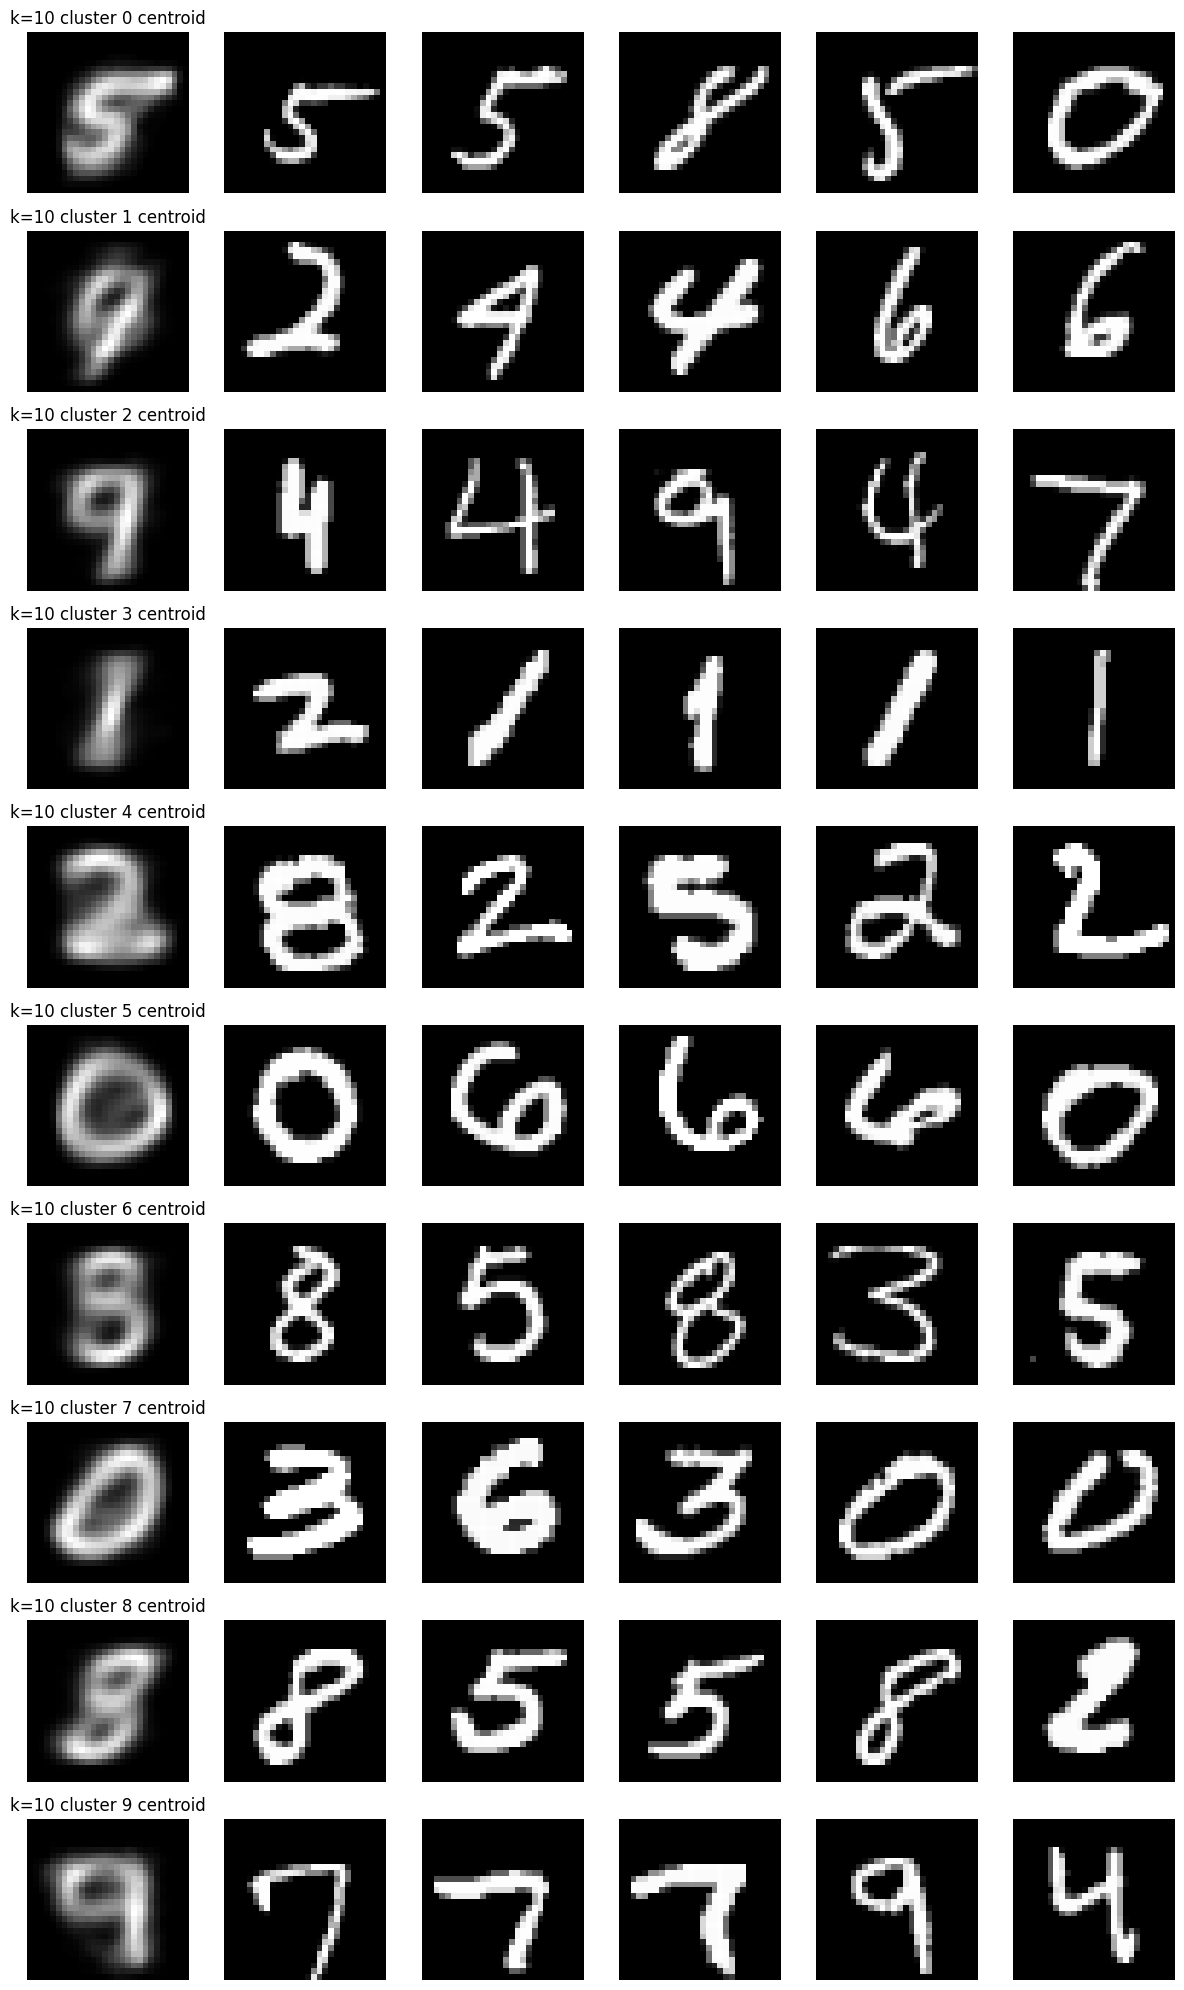

Random samples from clusters for k=3


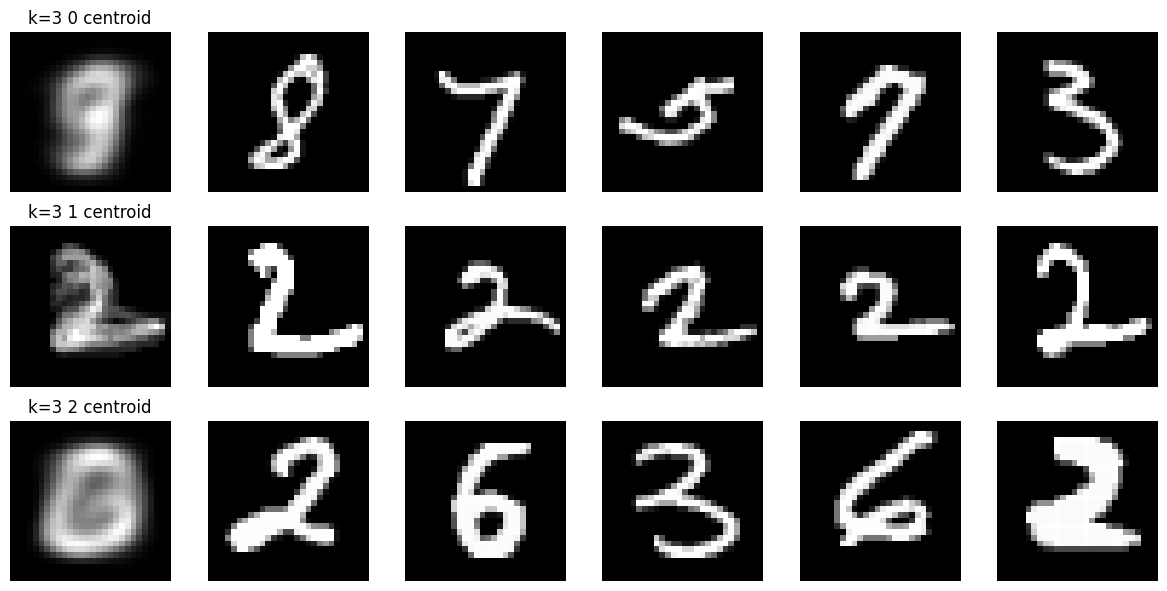

Random samples from clusters for k=7


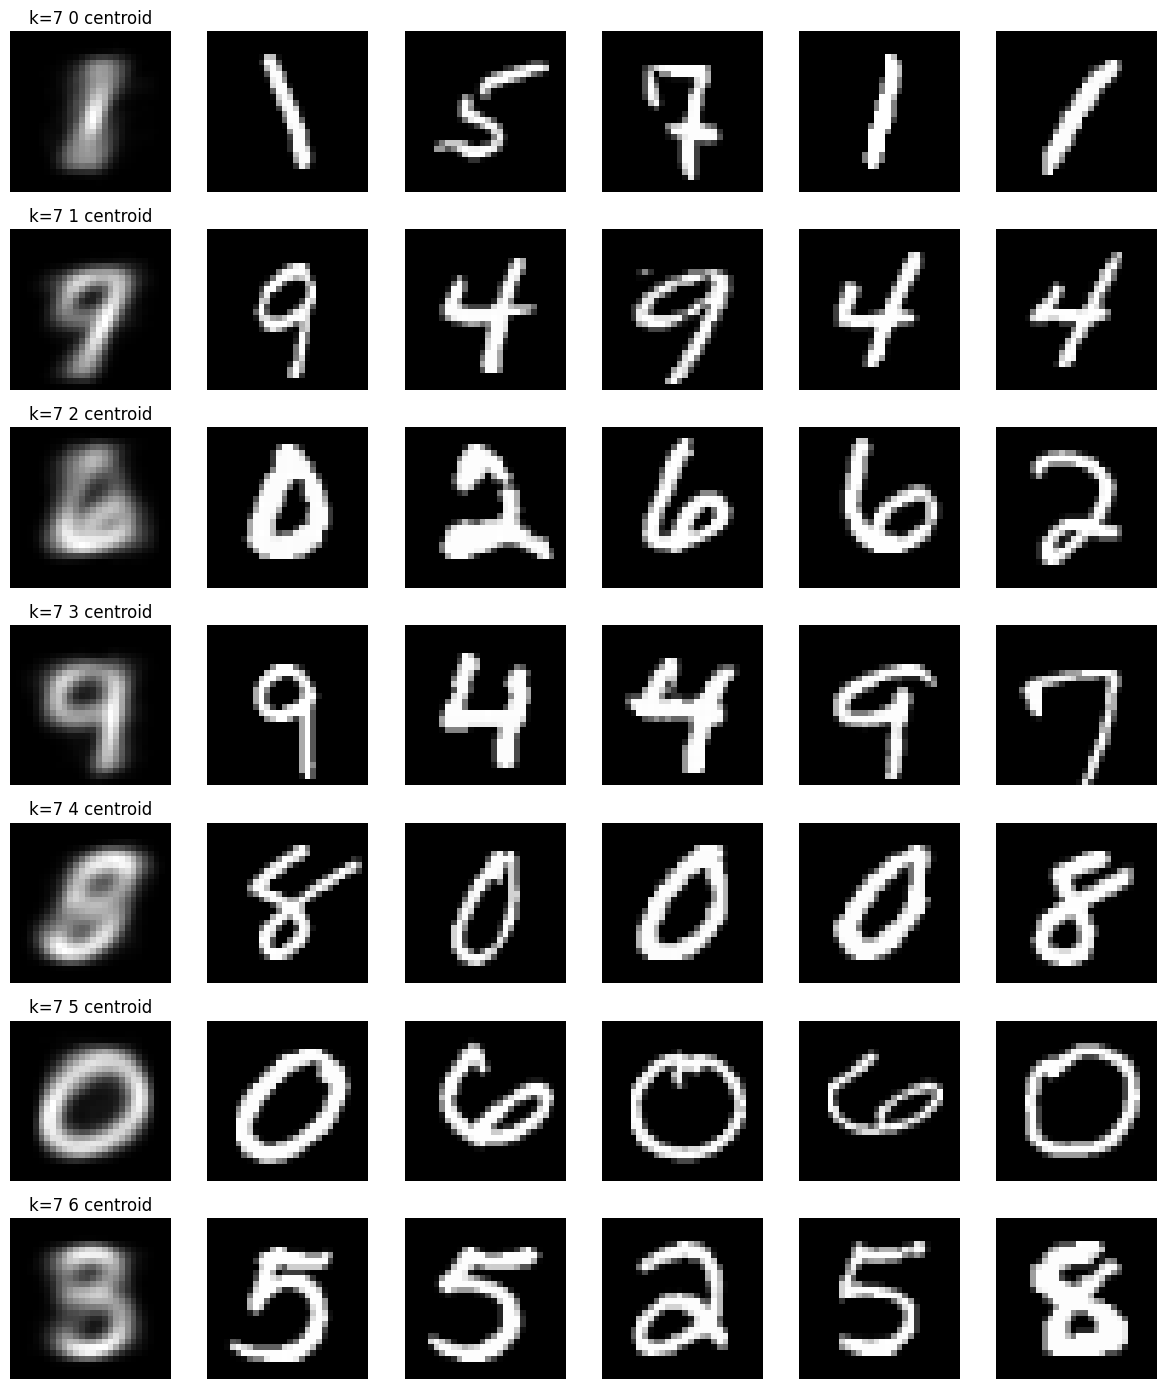

Random samples from clusters for k=20


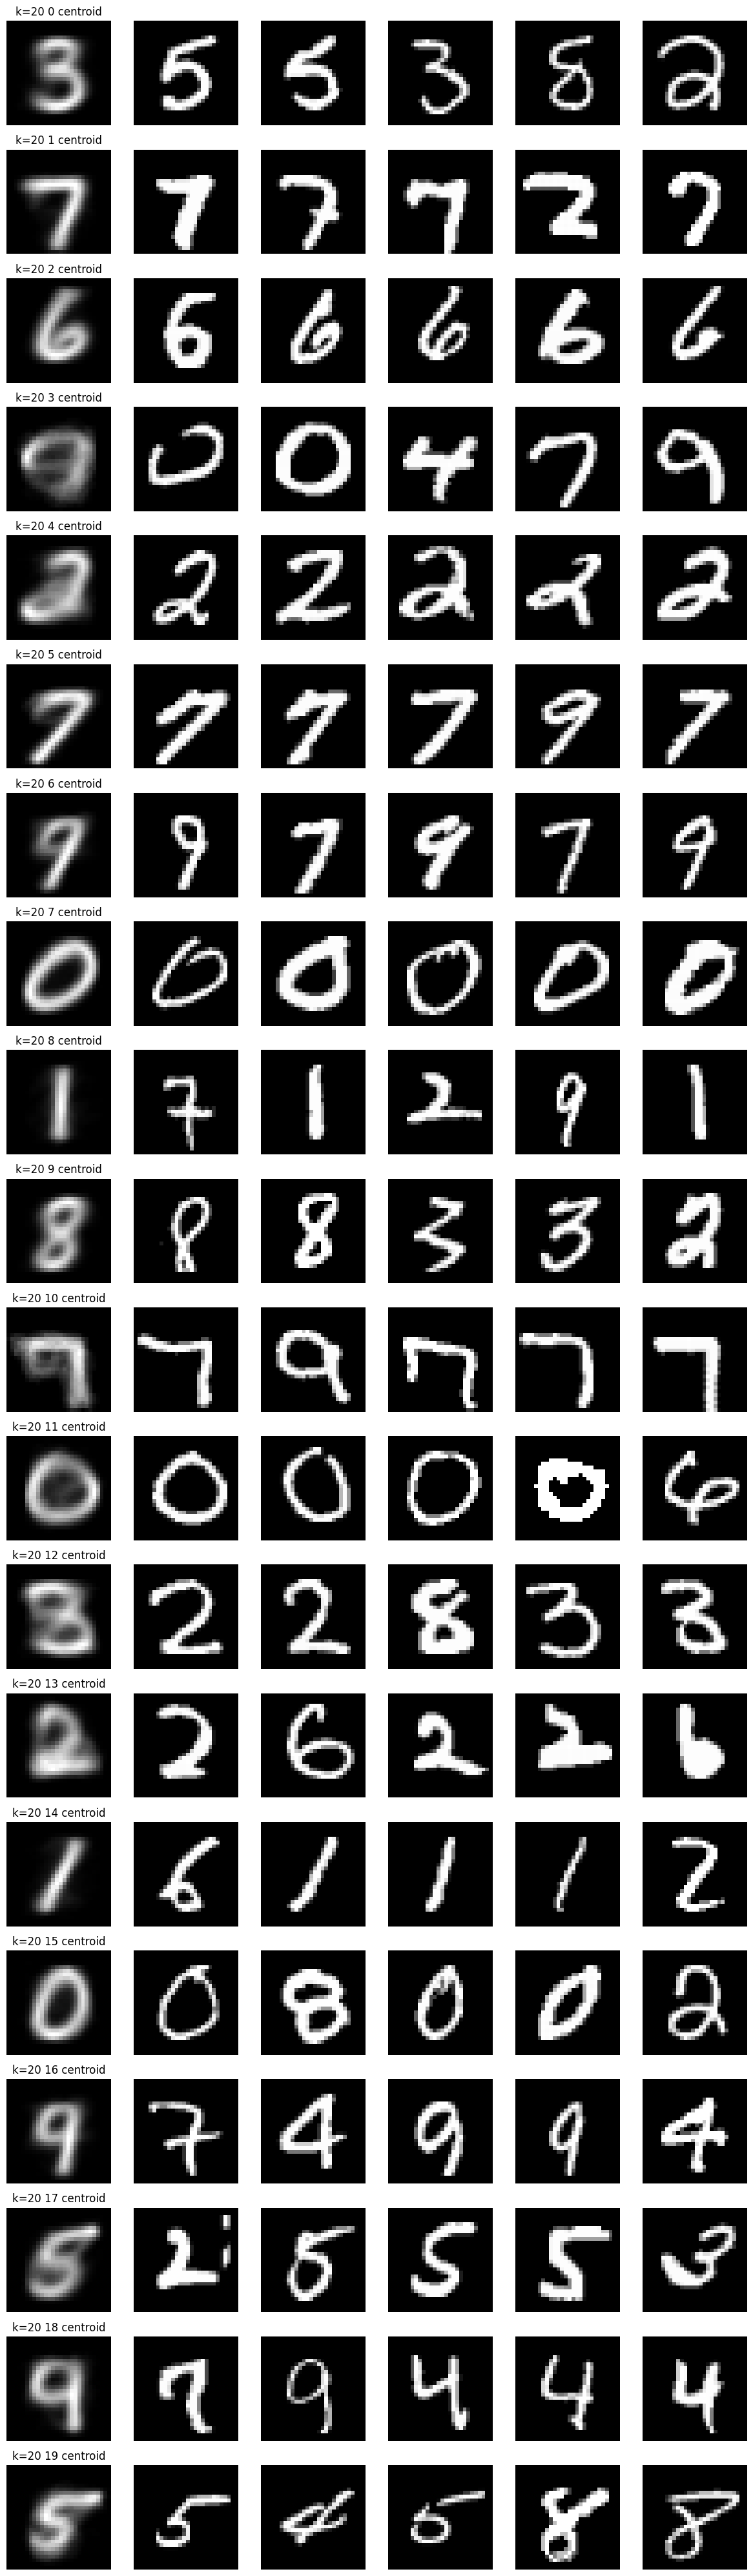

In [22]:
def display_random_examples(run, max_per_cluster=5, title_prefix=''):
    labels = run['labels']
    centers = scaler_kmeans.inverse_transform(run['centroids'])
    unique_clusters = len(run['centroids'])
    fig, axes = plt.subplots(unique_clusters, max_per_cluster + 1, figsize=(12, 2 * unique_clusters))
    if unique_clusters == 1:
        axes = axes[None, :]
    for cluster_idx in range(unique_clusters):
        axes[cluster_idx, 0].imshow(centers[cluster_idx].reshape(28, 28), cmap='gray')
        axes[cluster_idx, 0].set_title(f"{title_prefix} {cluster_idx} centroid")
        axes[cluster_idx, 0].axis('off')
        members = np.where(labels == cluster_idx)[0]
        if members.size > 0:
            chosen = rng_kmeans.choice(members, size=min(max_per_cluster, members.size), replace=False)
            for col_offset, idx_img in enumerate(chosen, start=1):
                axes[cluster_idx, col_offset].imshow(X_kmeans[idx_img].reshape(28, 28), cmap='gray')
                axes[cluster_idx, col_offset].axis('off')
            start_empty = 1 + len(chosen)
        else:
            start_empty = 1
        for col_offset in range(start_empty, max_per_cluster + 1):
            axes[cluster_idx, col_offset].axis('off')
    plt.tight_layout()
    plt.show()


k_display = 10
if k_display in kmeans_runs:
    display_random_examples(kmeans_runs[k_display], title_prefix='k=10 cluster')
else:
    print(f'Choose a display k that is in {list(kmeans_runs)}')

for k_show in [3, 7, 20]:
    if k_show in kmeans_runs:
        print(f'Random samples from clusters for k={k_show}')
        display_random_examples(kmeans_runs[k_show], title_prefix=f'k={k_show}')
    else:
        print(f'k={k_show} not available; choose from {list(kmeans_runs)}')


In [23]:
for k, run in kmeans_runs.items():
    counts = np.bincount(run['labels'], minlength=k)
    print(f'k={k:<2} cluster sizes: {counts}')


k=3  cluster sizes: [3470    8 1522]
k=7  cluster sizes: [1099  928  613  563  744  293  760]
k=10 cluster sizes: [169 851 799 916 255 237 776 348 495 154]
k=20 cluster sizes: [466 174 326  50 205  58 456 141 438 487  18 121 127 252 343 235 506 185
 258 154]


### K-means reflection prompts
- Compare the centroids for $k=10$ with the class means from the supervised section. Which digits are captured cleanly, and which mix together?
- Inspect the inertia values: does increasing $k$ beyond 10 provide meaningful gains given the extra complexity?
- Try projecting the clustered points into two discriminant directions or using PCA (as in ISLP Chapter 10) to visualize cluster separation.


### Reflection questions
- Which Fashion-MNIST classes share the most similar mean images? Why might that make classification harder?
- Compare the largest confusion pairs in Fashion-MNIST against MNIST. Does the pooled covariance seem to capture clothing variability as well as handwriting variability?
- If you wanted to improve accuracy, which assumption of LDA would you relax first? (Different covariances? Non-linear boundaries?) Explain your reasoning briefly.

> *Tip:* Save your answers in the notebook or discuss them in your write-up so you can revisit the reasoning when you study for exams.


Similar means: Shirts, coats, and pullovers look alike, which makes them harder to separate.

Confusions: Fashion-MNIST confuses clothing types more than MNIST digits, and LDA’s shared covariance doesn’t capture clothing differences well.

Improve accuracy: Drop the shared covariance assumption (use QDA or nonlinear boundaries) so the model can handle more variation.

## Takeaways

- Estimating the Gaussian parameters directly from the data gives transparent building blocks for LDA: sample means, a pooled covariance, and empirical class priors.
- Plugging those estimates into the ISLP discriminant formula yields a linear decision rule that performs well on MNIST, even with a reduced training set.
- Visual diagnostics—average digits, confusion matrices, and sampled predictions—make it easier to explain why the classifier succeeds or fails.
- Next steps: compare against logistic regression, experiment with more training examples, or explore quadratic discriminant analysis (QDA) where each digit gets its own covariance matrix.
